In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ants
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal

sys.path.insert(0, '/home/users/brezovec/projects/lysis/')
from bruker import *

%matplotlib inline

In [2]:
def load_brain(file, flip=False):
    try:
        brain = nib.load(file).get_data()
        #brain = np.swapaxes(brain, 0, 1)
        if flip is True:
            brain = np.flip(brain, 2)
        brain = np.squeeze(brain)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

def load_brains_from_dir(folder):
    brain_files = sorted(os.listdir(folder))
    full_brain_files = [folder+brain_file for brain_file in brain_files]
    brains = [load_brain(brain) for brain in full_brain_files]
    return brains

def rotate_brain(brain):
    try:
        if type(brain) is not np.ndarray:
            brain = brain.numpy()
        brain = np.swapaxes(brain, 0, 1)
        brain = ants.from_numpy(brain)
    except:
        brain = None
    return brain

In [3]:
def correlate_brain(brain, to_cor):
    try:
        brain_array = brain.numpy()
        y = np.shape(brain_array)[0]
        x = np.shape(brain_array)[1]
        z = np.shape(brain_array)[2]
        t = np.shape(brain_array)[3]
        print('y: {}, x: {}, z: {}, t: {}'.format(y, x, z, t))

        # first, flatten x and y
        print('flattening...')
        brain_for_cor = np.reshape(brain_array,(y*x,z,t))
        print('done flattening.')
        print('correlating...')
        cors = []
        for z_slice in range(z):
            print('Z-slice: ', z_slice)
            print('Shape of slice: ', np.shape(brain_for_cor[:,z_slice,:]))
            print('Shape of fictrac data: ', np.shape(to_cor[:,z_slice]))
            cors.append(np.corrcoef(brain_for_cor[:,z_slice,:], to_cor[:,z_slice])[-1,:])
        print('done correlating.')
        print('final touches...')
        cors = np.asarray(cors)

        # remove very last cor entry since this is self correlation
        cors = cors[:,:-1]

        #reshape back to correct brain shape
        cor_brain = np.reshape(cors,((z,y,x)))
        print('done.')
    except:
        print('try failed')
        cor_brain = None
    return cor_brain

### Create fly objects

In [4]:
class Fly:
    def __init__(self):
        pass

In [5]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]

In [6]:
flies = [Fly() for i in range(len(fly_folders))]

In [ ]:
flies

### Load motcorr brains

In [ ]:
for i, fly in enumerate(flies):
    print('Loading brain {} of {}'.format(i+1, len(flies)))
    brain_file = root_path+fly_folders[i]+'/motcorr.nii'
    fly.motcorr = load_brain(brain_file)

Loading brain 1 of 7
Loading brain 2 of 7
Loading brain 3 of 7
Loading brain 4 of 7
Loading brain 5 of 7
Loading brain 6 of 7
Loading brain 7 of 7


In [ ]:
fig = plt.figure(figsize=[20,3])
for i in range(len(flies)):
    plt.subplot(1,len(flies),i+1)
    try:
        plt.imshow(flies[i].motcorr[:,:,20,0])
    except:
        pass
    plt.title(i)

### Load imaging timestamps

In [26]:
for i, fly in enumerate(flies):
    file = root_path+fly_folders[i]
    fly.timestamps = bruker_timestamps_import(file, 'functional.xml', True)

extracting frame timestamps from bruker xml file... done
saving timestamp data as hdf5 file... done


### Load fictrac data

In [27]:
for i, fly in enumerate(flies):
    print('Loading fictrac data from fly {} of {}'.format(i+1, len(flies)))
    with open(os.path.join(root_path,fly_folders[i],'fictrac.dat'),'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)
        
    # Name columns
    df = df.rename(index=str, columns={0: 'frameCounter',
                                   1: 'dRotCamX',
                                   2: 'dRotCamY',
                                   3: 'dRotCamZ',
                                   4: 'dRotScore',
                                   5: 'dRotLabX',
                                   6: 'dRotLabY',
                                   7: 'dRotLabZ',
                                   8: 'AbsRotCamX',
                                   9: 'AbsRotCamY',
                                   10: 'AbsRotCamZ',
                                   11: 'AbsRotLabX',
                                   12: 'AbsRotLabY',
                                   13: 'AbsRotLabZ',
                                   14: 'positionX',
                                   15: 'positionY',
                                   16: 'heading',
                                   17: 'runningDir',
                                   18: 'speed',
                                   19: 'integratedX',
                                   20: 'integratedY',
                                   21: 'timeStamp',
                                   22: 'sequence'})
    
    # Remove commas
    for column in df.columns.values[:-1]:
        df[column] = [float(x[:-1]) for x in df[column]]
        
    fly.fictrac = df

Loading fictrac data from fly 1 of 1


# Correlate voxel activity to fictrac outputs

### Note: remove accidental extra frames from brain_4

In [41]:
flies[3].fictrac = flies[3].fictrac[:90000]

### Interpolate fictrac data to match imaging times

In [28]:
fps = 50
camera_rate = 1/fps * 1000 # camera frame rate in ms
dur = 30 * 60 * 1000 # experiment duration in ms
desired_fictrac_times = np.arange(0,dur,camera_rate)
# Warning: interp1d set to fill in out of bounds times

for i, fly in enumerate(flies):
    print('Interpolating fictrac data from fly {} of {}'.format(i+1, len(flies)))
    #try:
    print(len(desired_fictrac_times))
    print(len(fly.fictrac['speed']))
    fictrac_interp_temp = interp1d(desired_fictrac_times, fly.fictrac['speed'], bounds_error = False)
    fictrac_interp = fictrac_interp_temp(fly.timestamps)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    #except:
        #print('Try clause failed')
        #fictrac_interp = None
        
    fly.fictrac_interp = fictrac_interp

Interpolating fictrac data from fly 1 of 1
90000
90000


### Correlate each voxel

In [29]:
for i, fly in enumerate(flies):
    print('Running analysis on fly {} of {}'.format(i+1, len(flies)))
    fly.cor_brain = correlate_brain(fly.motcorr, fly.fictrac_interp)

Running analysis on fly 1 of 1
y: 88, x: 128, z: 55, t: 4006
flattening...
done flattening.
correlating...
0
1, (11264, 4006)
2, (4006,)
1
1, (11264, 4006)
2, (4006,)
2
1, (11264, 4006)
2, (4006,)
3
1, (11264, 4006)
2, (4006,)
4
1, (11264, 4006)
2, (4006,)
5
1, (11264, 4006)
2, (4006,)
6
1, (11264, 4006)
2, (4006,)
7
1, (11264, 4006)
2, (4006,)
8
1, (11264, 4006)
2, (4006,)
9
1, (11264, 4006)
2, (4006,)
10
1, (11264, 4006)
2, (4006,)
11
1, (11264, 4006)
2, (4006,)
12
1, (11264, 4006)
2, (4006,)
13
1, (11264, 4006)
2, (4006,)
14
1, (11264, 4006)
2, (4006,)
15
1, (11264, 4006)
2, (4006,)
16
1, (11264, 4006)
2, (4006,)
17
1, (11264, 4006)
2, (4006,)
18
1, (11264, 4006)
2, (4006,)
19
1, (11264, 4006)
2, (4006,)
20
1, (11264, 4006)
2, (4006,)
21
1, (11264, 4006)
2, (4006,)
22
1, (11264, 4006)
2, (4006,)
23
1, (11264, 4006)
2, (4006,)
24
1, (11264, 4006)
2, (4006,)
25
1, (11264, 4006)
2, (4006,)
26
1, (11264, 4006)
2, (4006,)
27
1, (11264, 4006)
2, (4006,)
28
1, (11264, 4006)
2, (4006,)
29
1

### Save speed_cor maps

In [ ]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/warped_anatomy/meanbrain.nii'
ants.image_write(ants.from_numpy(mean_brain), save_file)

In [57]:
np.shape(flies[0].cor_brain)

(55, 88, 128)

In [30]:
for i, fly in enumerate(flies):
    print(i)
    try:
        fly.cor_brain = np.swapaxes(fly.cor_brain, 0, 2)
    except:
        print('Try clause failed')

0


In [31]:
for i, fly in enumerate(flies):
    print('Saving file {} of {}'.format(i+1, len(flies)))
    try:
        save_file = os.path.join(root_path, fly_folders[i], 'speed_correlation.nii')
        ants.image_write(ants.from_numpy(fly.cor_brain), save_file)
    except:
        print('Try clause failed')

Saving file 1 of 1


In [20]:
flies[1].cor_brain

In [4]:
nib_brain = nib.load(brain_file).get_data()
#nib_brain = np.swapaxes(nib_brain, 0, 1)
brain = ants.from_numpy(nib_brain)

In [5]:
meanbrain = brain.mean(3)
meanbrain = ants.from_numpy(meanbrain)

In [5]:
save_file = '/scratch/users/brezovec/motcorred'

In [ ]:
motCorr_brain = []
t0 = time()
for i in range(np.shape(nib_brain)[3]):
    print(i)
    brain_slice = ants.from_numpy(nib_brain[:,:,:,i])
    motCorr_slice = ants.registration(meanbrain, brain_slice, type_of_transform='SyN')
    motCorr_slice = motCorr_slice['warpedmovout'].numpy()
    motCorr_brain.append(motCorr_slice)
    
np.save(save_file, motCorr_brain)
print(time()-t0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [14]:
motCorr_brain = np.moveaxis(np.asarray(motCorr_brain),0,3)
motCorr_brain_ants = ants.from_numpy(motCorr_brain)

In [15]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181127/fly1/mean.nii'

In [18]:
ants.image_write(meanbrain, save_file)

In [13]:
downsamp = nib_brain[:,:,:,600:700]
downsamp = ants.from_numpy(downsamp)
ants.image_write(downsamp, save_file)

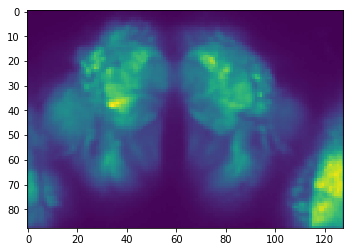

In [7]:
plt.imshow(meanbrain[:,:,40])

In [16]:
### Get fictrac timing info ###

# probably just 0 (defines the start of whole imaging session)

xml_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/TSeries-12172018-1322-001.xml'

tree = ET.parse(xml_file)
root = tree.getroot()

sequence = int(root.find('Sequence').find('VoltageOutput').get('relativeTime'))

In [5]:
### Get Bruker timestamps ###
# just load h5py file next time below

exp_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/'
xml_file = 'TSeries-12172018-1322-001.xml'

timestamps = bruker_timestamps_import(exp_dir, xml_file, False)

loading timestamp data from hdf5 file... done


In [6]:
np.shape(timestamps)

(4006, 55)

In [4]:
### Load nii ###
motcor_brain_file = '/scratch/users/brezovec/nii_work/ants_mot_cor.nii'
nib_brain = nib.load(motcor_brain_file).get_data()
brain = ants.from_numpy(nib_brain)

In [7]:
### Load Fictrac Data ###

with open('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181226_meanbrain_creation/fictrac/brain_1.dat','r') as f:
    df = pd.DataFrame(l.rstrip().split() for l in f)

In [8]:
df = df.rename(index=str, columns={0: 'frameCounter',
                                   1: 'dRotCamX',
                                   2: 'dRotCamY',
                                   3: 'dRotCamZ',
                                   4: 'dRotScore',
                                   5: 'dRotLabX',
                                   6: 'dRotLabY',
                                   7: 'dRotLabZ',
                                   8: 'AbsRotCamX',
                                   9: 'AbsRotCamY',
                                   10: 'AbsRotCamZ',
                                   11: 'AbsRotLabX',
                                   12: 'AbsRotLabY',
                                   13: 'AbsRotLabZ',
                                   14: 'positionX',
                                   15: 'positionY',
                                   16: 'heading',
                                   17: 'runningDir',
                                   18: 'speed',
                                   19: 'integratedX',
                                   20: 'integratedY',
                                   21: 'timeStamp',
                                   22: 'sequence'})

In [9]:
#Remove commas
for column in df.columns.values[:-1]:
    df[column] = [float(x[:-1]) for x in df[column]]

Text(0.5, 1.0, 'fly on a ball')

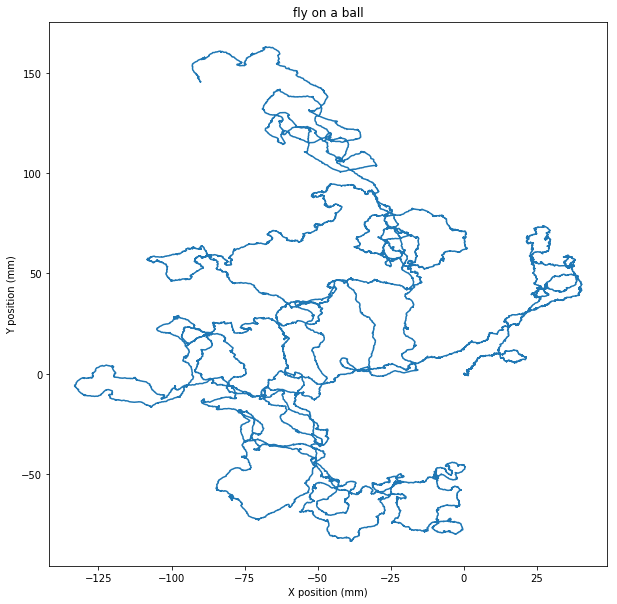

In [10]:
sphere_radius = 4.5e-3
plt.figure(figsize=(10,10))
plt.plot(df['positionX']*sphere_radius*1000, df['positionY']*sphere_radius*1000)
#plt.xlim(-10,45)
#plt.ylim(-40,15)
plt.xlabel('X position (mm)')
plt.ylabel('Y position (mm)')
plt.title('fly on a ball')
#plt.savefig('myimage300.png', format='png', dpi=300)

(-249.95000000000002, 5248.95, -0.0014352132982042001, 0.0301394792622882)

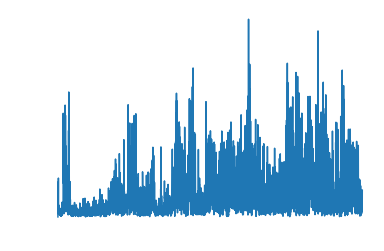

In [12]:
plt.plot(df['speed'][:5000])
plt.axis('off')

In [9]:
len(df['speed'])

90000

# Correlate voxel activity to fictrac outputs

### First, interpolate fictrac data to match imaging times ###

In [11]:
fps = 50
camera_rate = 1/fps * 1000 # camera frame rate in ms
dur = 30 * 60 * 1000 # experiment duration in ms


raw_fictrac_times = np.arange(0,dur,camera_rate)
# Warning: interp1d set to fill in out of bounds times
fictrac_interp_temp = interp1d(raw_fictrac_times, df['speed'], bounds_error = False)
fictrac_interp = fictrac_interp_temp(timestamps)

# Replace Nans with zeros (for later code)
np.nan_to_num(fictrac_interp, copy=False);

### Verify interpolation

Text(0.5, 1.0, 'zoomin')

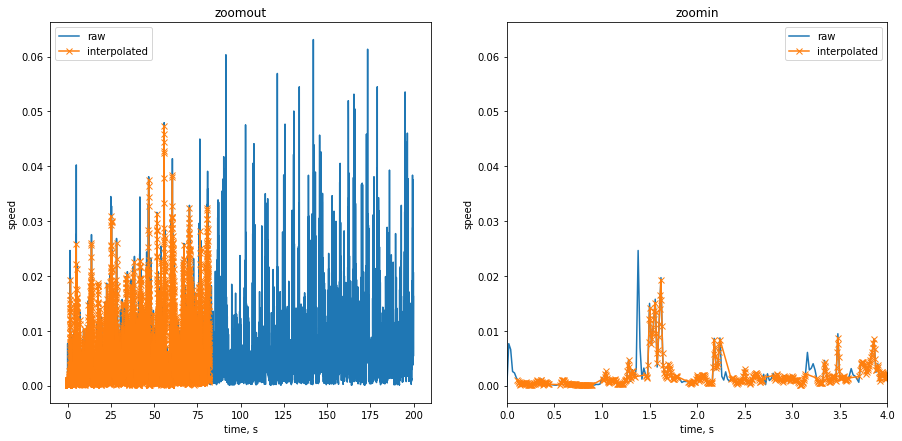

In [12]:
# Verify interpolation is working well, and visualize if "kind" is optimal:
fictrac_interp_flat = np.ndarray.flatten(fictrac_interp)
timestamps_flat = np.ndarray.flatten(timestamps)

fig = plt.figure(figsize=(15,7))

start = 0
end = 10000

plt.subplot(1,2,1)
plt.plot(raw_fictrac_times[start:end]/1000, df['speed'][start:end], label = 'raw')
plt.plot(timestamps_flat[start:end]/1000, fictrac_interp_flat[start:end], label = 'interpolated', marker='x')
plt.legend()
plt.title('zoomout')
plt.xlabel('time, s')
plt.ylabel('speed')

plt.subplot(1,2,2)
plt.plot(raw_fictrac_times[start:end]/1000, df['speed'][start:end], label = 'raw')
plt.plot(timestamps_flat[start:end]/1000, fictrac_interp_flat[start:end], label = 'interpolated', marker='x')
plt.xlim(0,4)
plt.legend()
plt.xlabel('time, s')
plt.ylabel('speed')
plt.title('zoomin')

##### looks good. note: sampling of fictrac data is in temporal bursts, representing one volume (z-stack). note: consider temporally smoothing fictrac data

### Correlate each voxel

In [18]:
np.shape(np.asarray(brain))

()

In [20]:
np.asarray(brain)

array(ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (88, 128, 55, 4006)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
, dtype=object)

In [29]:
cor_brain = correlate_brain(brain=brain, to_cor=fictrac_interp)

flattening...
brain_for_cor shape: (11264, 55, 4006)
done flattening.
correlating...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
done correlating.
final touches...
cors shape:  (55, 11265)
after removal: (55, 11264)
done.


In [20]:
### Calculate z-scored brain

brain_array = np.asarray(nib_brain)
meanbrain = brain.mean(3)

brain_std = np.std(brain_array, axis=3)

brain_z = (brain_array-meanbrain[:,:,:,None])/brain_std[:,:,:,None]

In [75]:
z=20
test = (np.corrcoef(brain_for_cor[:,z,:], fictrac_interp[:,z]))

In [38]:
np.shape(cor_brain)

(55, 88, 128)

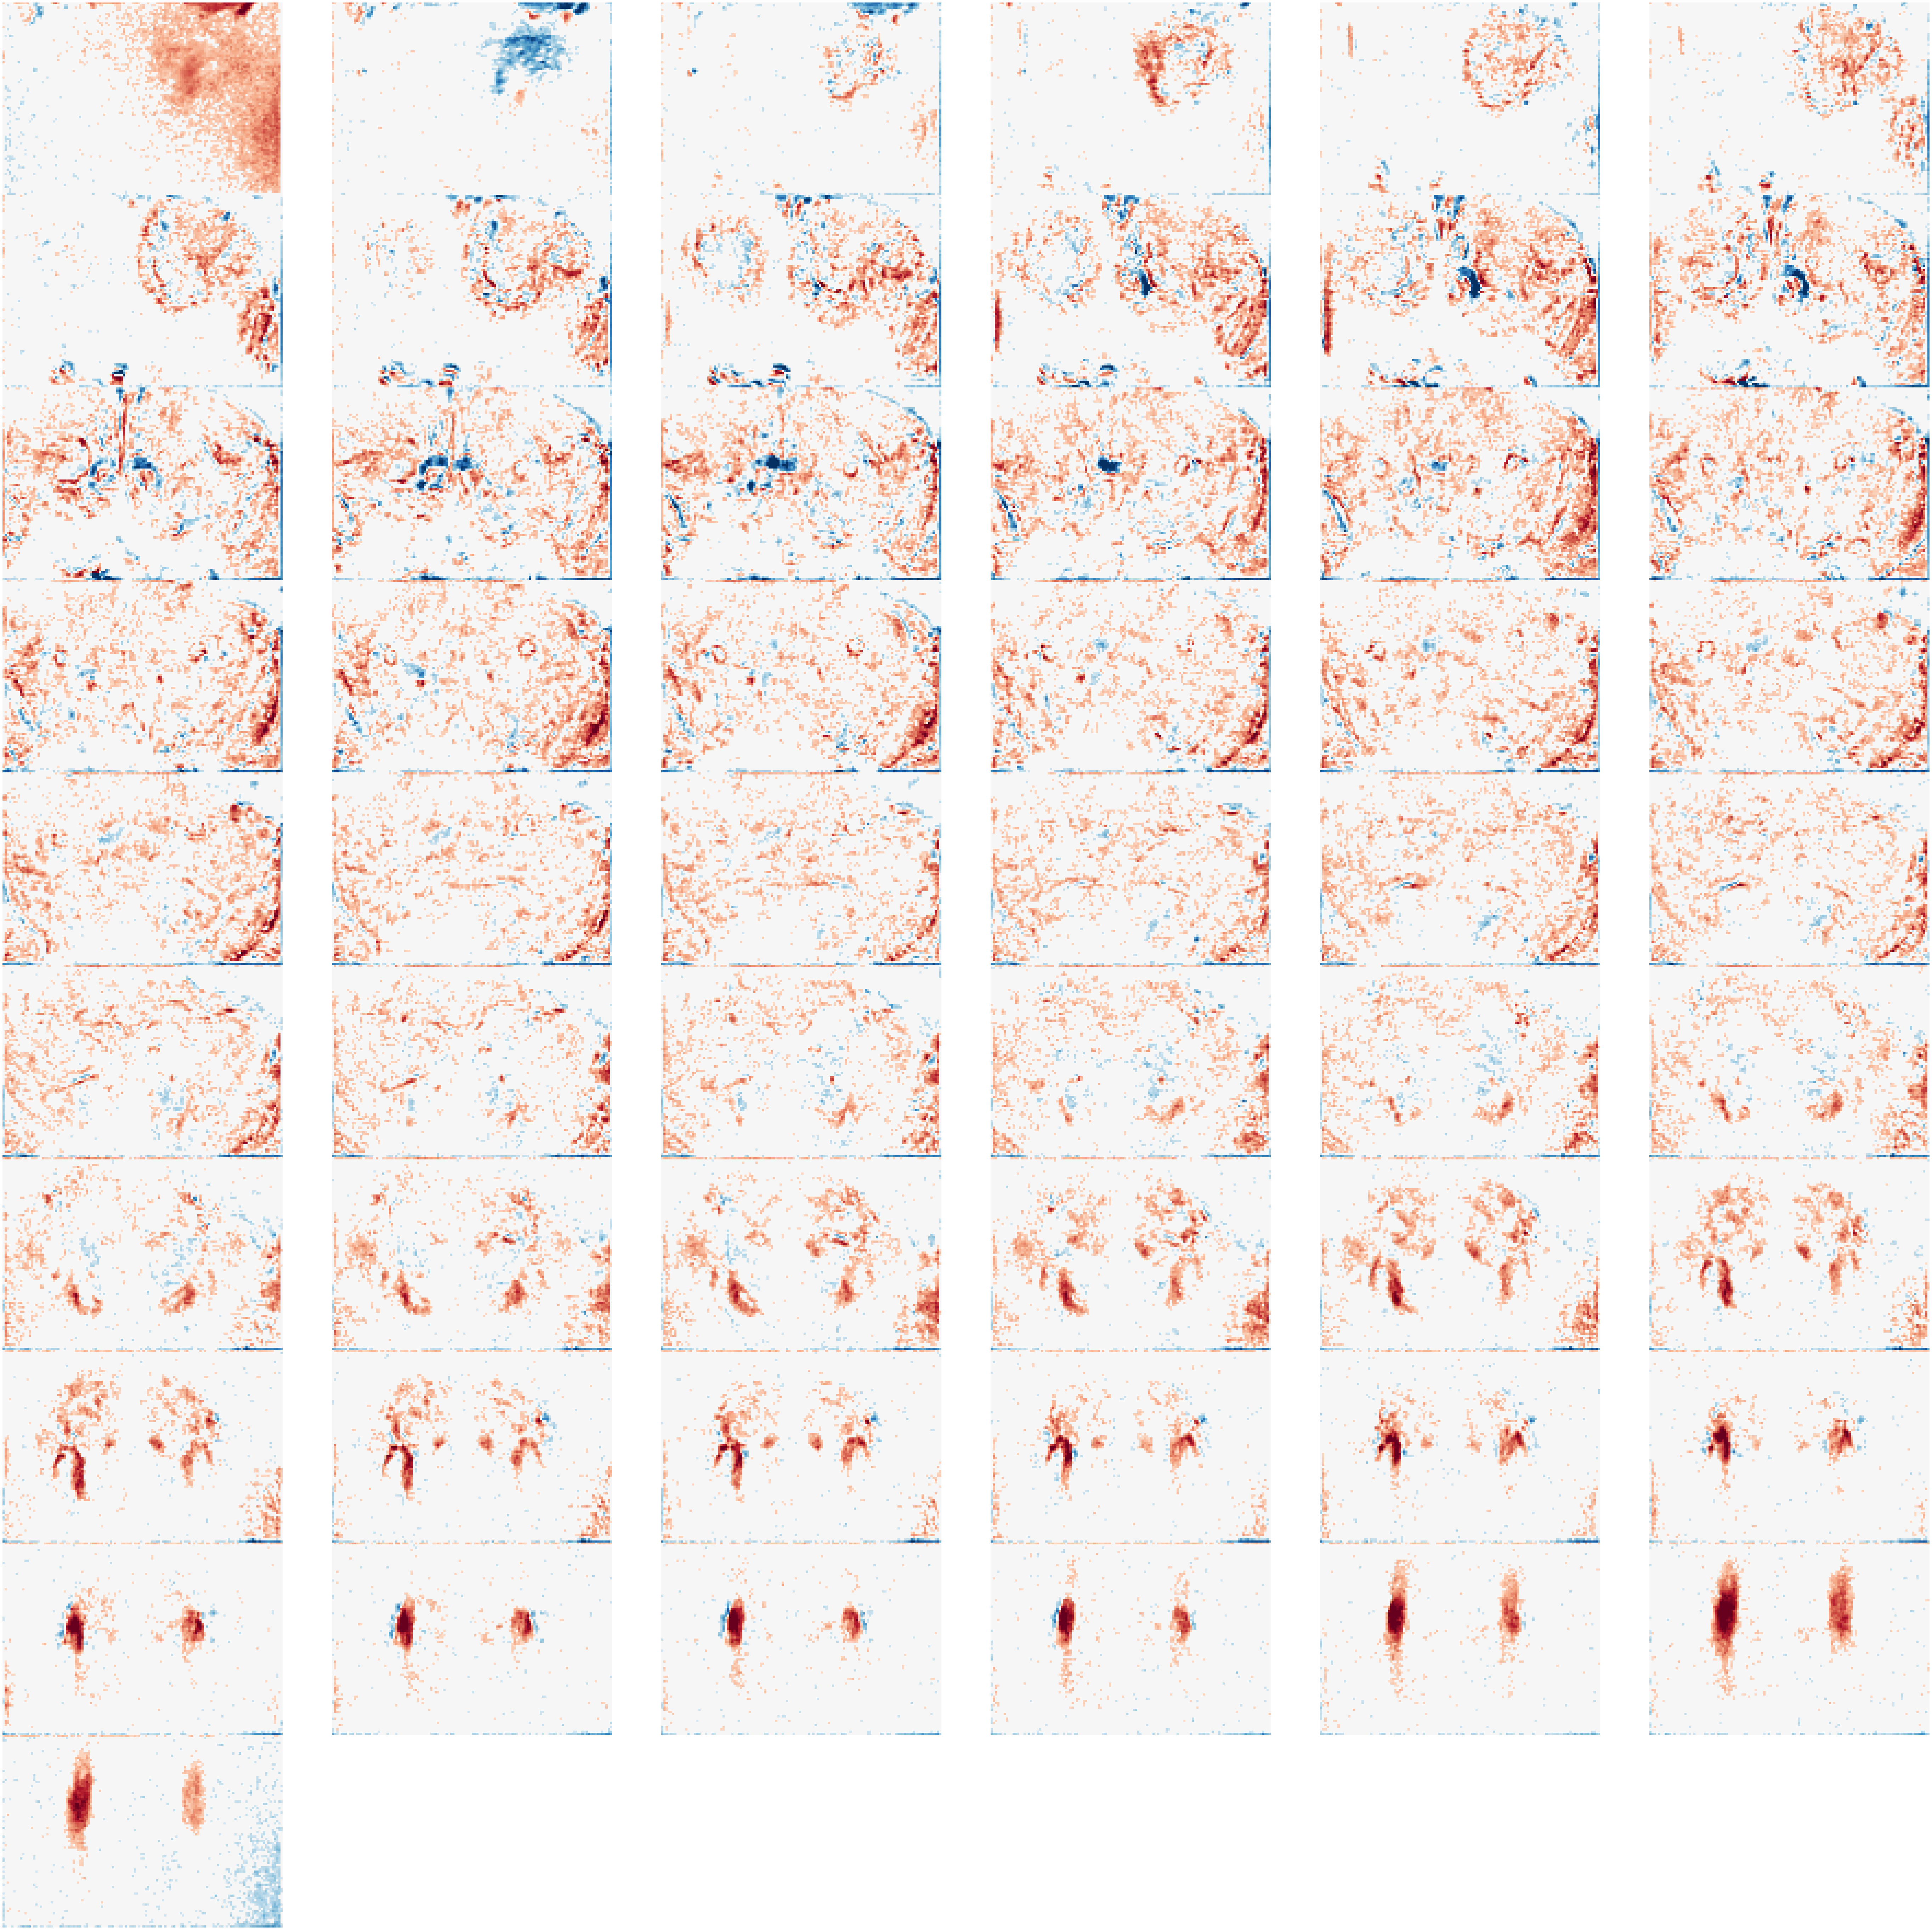

In [32]:
fig = plt.figure(figsize=(100,100))
threshold_high = 0.04
threshold_low = -0.04
plt.set_cmap('RdBu')
for z in range(55):
    plt.subplot(10,6,z+1)
    data = np.copy(cor_brain[z,:,:])
    data[np.where((data<threshold_high) & (data>threshold_low))]=0

    plt.imshow(data, vmin = -0.2, vmax = 0.2)
    
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')

NameError: name 'cor_brain' is not defined

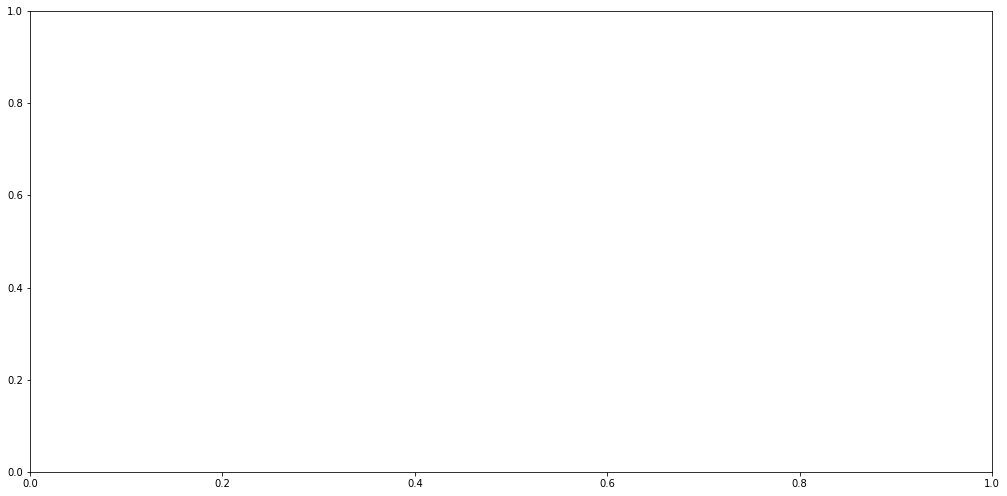

In [60]:
fig = plt.figure(figsize=(100,100))
threshold_high = 0.04
threshold_low = -0.04
plt.set_cmap('RdBu')
for z in range(41):
    plt.subplot(10,5,z+1)
    data = np.copy(cor_brain[:,:,z])
    data[np.where((data<threshold_high) & (data>threshold_low))]=0

    plt.imshow(data, vmin = -0.2, vmax = 0.2)
    
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')

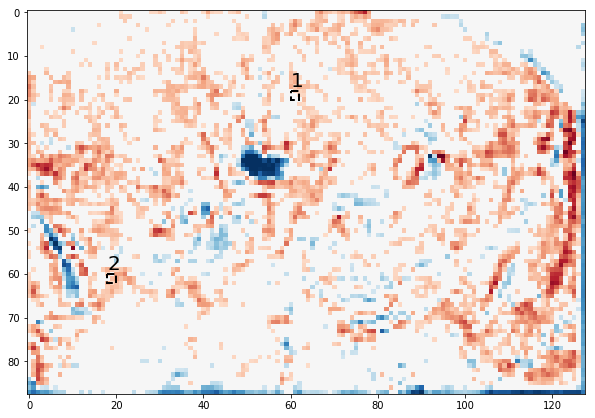

In [36]:
fig = plt.figure(figsize=(10,10))

threshold_high = 0.04
threshold_low = -0.04
plt.set_cmap('RdBu')
z = 15

data = np.copy(cor_brain[z,:,:])
data[np.where((data<threshold_high) & (data>threshold_low))]=0

ax = fig.add_subplot(111)
ax.imshow(data, vmin = -0.2, vmax = 0.2)

boxes = [(60,18),(18,60)]
for num, box in enumerate(boxes):
    rect = patches.Rectangle((box[0],box[1]),2,2,linewidth=2,edgecolor='black',facecolor='none',ls='--')
    ax.add_patch(rect)
    ax.annotate(num+1, fontsize=20, xy=(box[0], box[1]-1),xycoords='data')

In [13]:
cor_brain[12,18,60]

0.12787421837511093

In [14]:
cor_brain.shape

(41, 65, 129)

In [15]:
brain_z.shape

(65, 129, 41, 5805)

In [ ]:
# cor_brain is [z,y,x]
# brain_z is [y,x,z,t]

In [21]:
y = 18
x = 60
z= 12

smo = gaussian_filter(brain_z[y,x,z,:],sigma=2,mode='nearest')

In [26]:
z_fictrac = (fictrac_interp[:,12]-np.mean(fictrac_interp[:,12]))/np.std(fictrac_interp[:,12])

(5, 8)

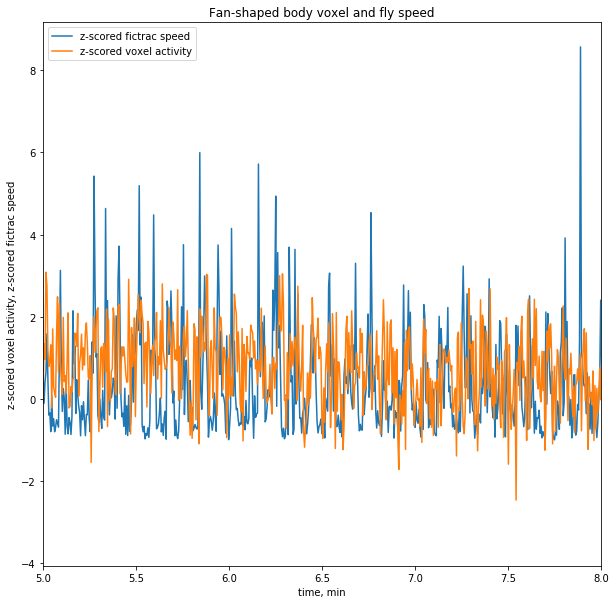

In [31]:
fig = plt.figure(figsize=(10,10))
#plt.plot(brain_z[60,18,12,:])
plt.plot(timestamps[:,12]/1000/60, z_fictrac, label = 'z-scored fictrac speed')
plt.plot(timestamps[:,12]/1000/60, brain_z[y,x,z,:], label = 'z-scored voxel activity')
plt.legend()
plt.ylabel('z-scored voxel activity, z-scored fictrac speed')
plt.xlabel('time, min')
plt.title('Fan-shaped body voxel and fly speed')
plt.xlim(5,8)

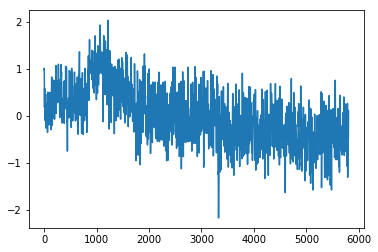

In [23]:
plt.plot(smo)

(array([  1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,
          1.,   2.,   3.,   4.,   3.,   7.,   4.,   6.,   8.,   9.,  13.,
         15.,  15.,  22.,  19.,  31.,  27.,  34.,  53.,  46.,  75.,  75.,
         76.,  90.,  84., 107., 118., 104., 126., 127., 144., 135., 161.,
        148., 166., 155., 146., 165., 157., 171., 179., 164., 147., 154.,
        170., 130., 147., 141., 131., 113., 109., 117., 117., 104.,  86.,
         88.,  95.,  93.,  70.,  54.,  42.,  61.,  70.,  55.,  54.,  42.,
         44.,  24.,  25.,  18.,  28.,  18.,   8.,  15.,   3.,   3.,   6.,
          4.,   2.,   2.,   2.,   3.,   3.,   0.,   0.,   2.,   1.,   2.,
          1.]),
 array([-2.17531872, -2.13327974, -2.09124077, -2.04920179, -2.00716282,
        -1.96512384, -1.92308487, -1.88104589, -1.83900692, -1.79696795,
        -1.75492897, -1.71289   , -1.67085102, -1.62881205, -1.58677307,
        -1.5447341 , -1.50269512, -1.46065615, -1.41861717, -1.3765782 ,
        -1.33453922, -1.29

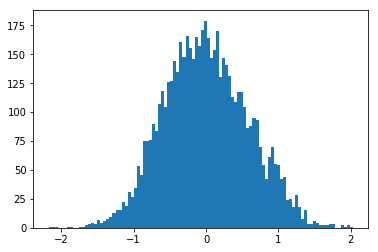

In [25]:
plt.hist(smo, bins = 100)

### Try cross-correlation

Text(0.5, 0, 'time, s')

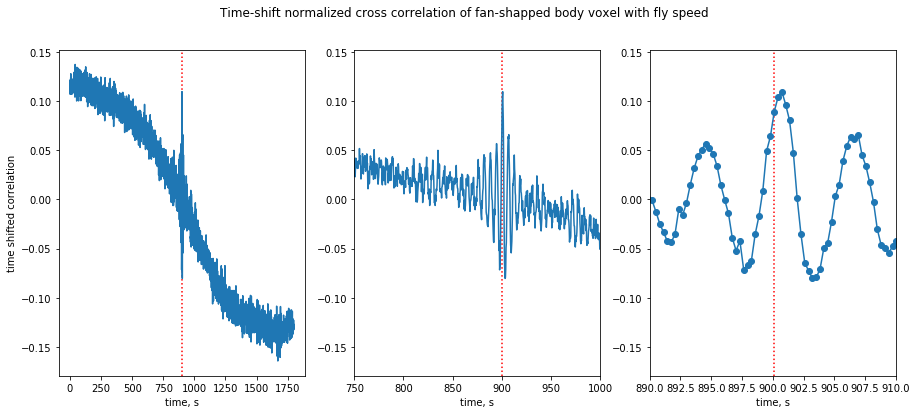

In [34]:
fig = plt.figure(figsize=(15,6))
plt.suptitle('Time-shift normalized cross correlation of fan-shapped body voxel with fly speed')

a = brain_z[18,60,12,:]
b = fictrac_interp[:,12]
cross_cor = signal.correlate(a, b,'same')/np.sqrt(np.sum(np.square(a))*np.sum(np.square(b)))

zero_shift = int(np.floor(len(cross_cor)/2))
plt.subplot(131)
plt.axvline(timestamps[zero_shift,12]/1000, color='r', linestyle=':')
plt.plot(timestamps[:,12]/1000, cross_cor)
plt.xlabel('time, s')
plt.ylabel('time shifted correlation')

plt.subplot(132)
plt.axvline(timestamps[zero_shift,12]/1000, color='r', linestyle=':')
plt.plot(timestamps[:,12]/1000, cross_cor)
plt.xlim(750,1000)
plt.xlabel('time, s')

plt.subplot(133)
plt.axvline(timestamps[zero_shift,12]/1000, color='r', linestyle=':')
plt.plot(timestamps[:,12]/1000, cross_cor, marker='o')
plt.xlim(890,910)
plt.xlabel('time, s')

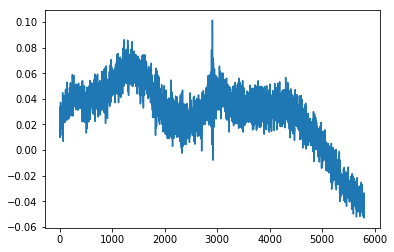

In [157]:
a = brain_z[60,18,12,:]
b = fictrac_interp[:,12]
cor = signal.correlate(a, b,'same')/np.sqrt(np.sum(np.square(a))*np.sum(np.square(b)))
plt.plot(cor)

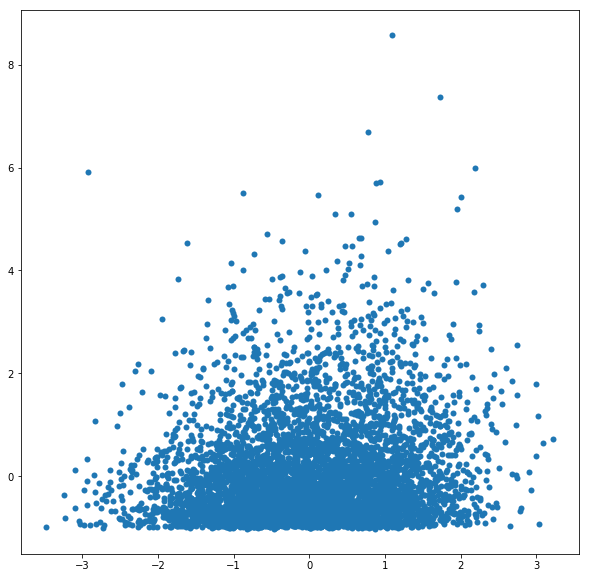

In [47]:
fig = plt.figure(figsize=(10,10))
plt.scatter(brain_z[18,60,12,:], z_fictrac, linewidths=0.0002)

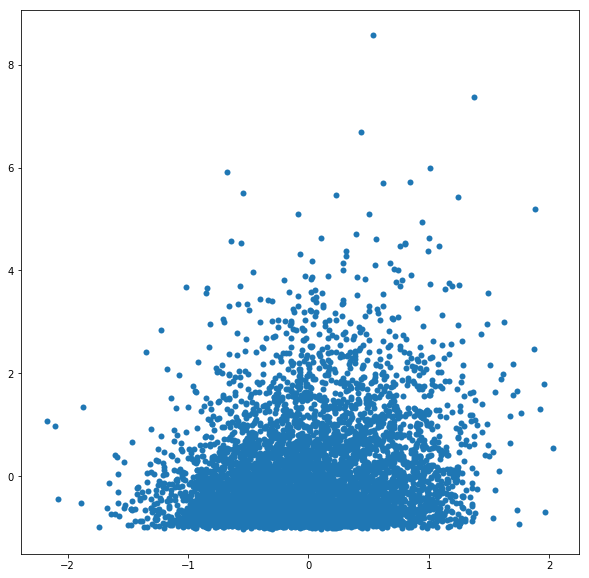

In [48]:
fig = plt.figure(figsize=(10,10))
plt.scatter(smo, z_fictrac, linewidths=0.0002)

In [46]:
timestamps[np.argmax(cross_cor[2000:])+2000,12] - timestamps[zero_shift,12]

620.2332439998863

In [41]:
timestamps[np.argmax(cross_cor[2000:]),12]

280510.488361

In [44]:
zero_shift

2902

In [43]:
timestamps[zero_shift,12]

900123.499117

In [45]:
timestamps.shape

(5805, 41)

In [40]:
np.argmax(cross_cor[2000:])

904

In [38]:
len(cross_cor)

5805

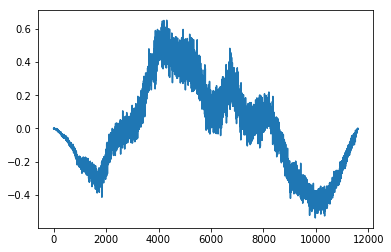

In [150]:
cross_cor = np.convolve(brain_z[60,18,12,:], fictrac_interp[:,12])
plt.plot(cross_cor)

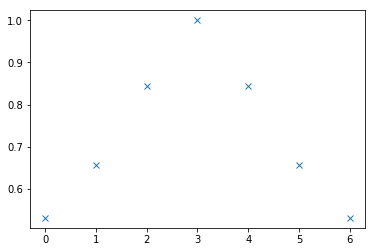

In [156]:
a = [1,2,3,2,2,3,1]
b = [1,2,3,2,2,3,1]
c = signal.correlate(a,b,'same')/np.sqrt(np.sum(np.square(a))*np.sum(np.square(b)))
plt.plot(c,'x')

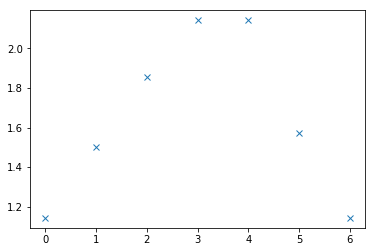

In [155]:
a = [1,2,3,2,2,3,1]
b = [1,2,3,2,2,3,1]
c = np.convolve(a,b,'same')/np.sqrt(np.sum(a)*np.sum(b))
plt.plot(c,'x')

In [100]:
int(np.floor(len(a)/2))

3

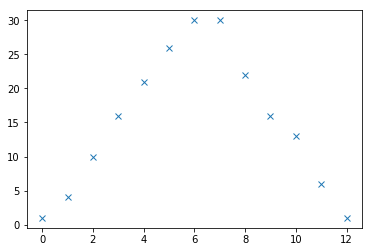

In [94]:
a = [1,2,3,2,2,3,1]
b = [1,2,3,2,2,3,1]
c = np.convolve(a,b)
plt.plot(c,'x')

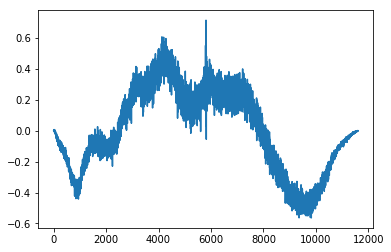

In [79]:
plt.plot(cross_cor)

In [86]:
len(cross_cor)

5805

In [82]:
len(brain_z[60,18,12,:])

5805

In [68]:
fictrac_interp.shape

(5805, 41)

Text(0, 0.5, '|Y(freq)|')

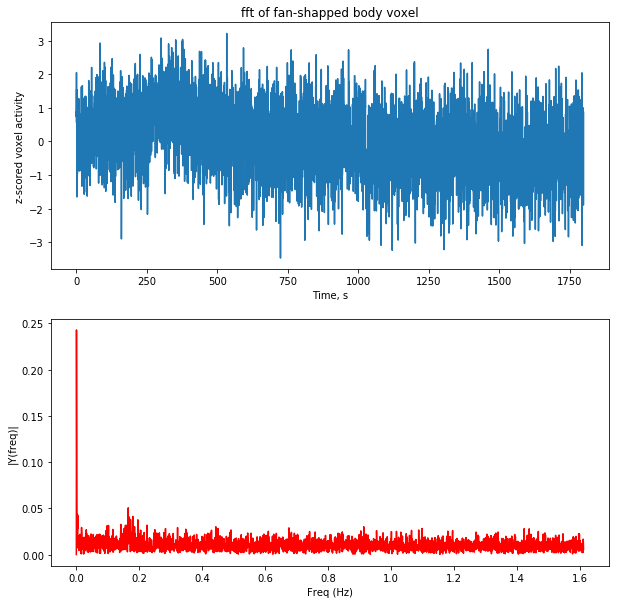

In [33]:
Fs = 3.225;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1800,Ts) # time vector

y = brain_z[18,60,12,:]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]


fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(t,y)
plt.xlabel('Time, s')
plt.ylabel('z-scored voxel activity')
plt.title('fft of fan-shapped body voxel')

plt.subplot(212)
plt.plot(frq,abs(Y),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
#plt.ylim(0,.002)
#plt.xlim(-.1,.5)

(0, 0.002)

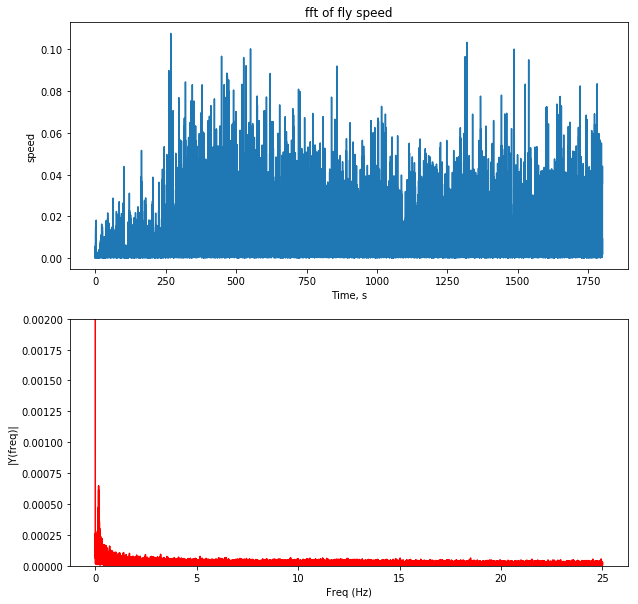

In [59]:
Fs = 50;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1800,Ts) # time vector

y = df['speed']

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]


fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(t,y)
plt.xlabel('Time, s')
plt.ylabel('speed')
plt.title('fft of fly speed')

plt.subplot(212)
plt.plot(frq,abs(Y),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.ylim(0,.002)

In [55]:
1/6

0.16666666666666666

In [43]:
len(df['speed'])

90000

Text(0, 0.5, '|Y(freq)|')

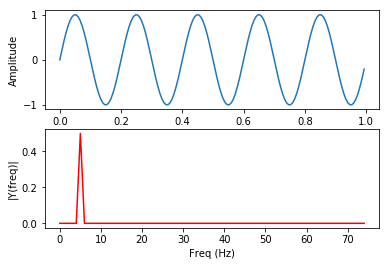

In [193]:
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

In [187]:
range(150/2)

TypeError: 'float' object cannot be interpreted as an integer

In [64]:
np.shape(cors)

(41, 8386)

In [67]:
cors.shape

(41, 8385)

In [30]:
np.shape(brain)

(65, 129, 41, 5805)

In [42]:
65*129

8385

In [36]:
np.shape(cors[0])

()

In [19]:
fictrac_interp.shape

(5805, 41)

In [23]:
cors.shape

(8386, 8386)

In [33]:
y = [1,2,3]
y[:-1]

[1, 2]

In [20]:
brain_for_cor.shape

(343785, 5805)

In [24]:
65*129

8385

In [15]:
brain_array

array([[[[   0.      ,    0.      ,   15.898038, ...,    0.      ,
             0.      ,    0.      ],
         [  20.850292,   37.836582,   23.153685, ...,    0.      ,
             0.      ,    0.      ],
         [  29.60851 ,   42.07411 ,   27.051884, ...,    0.      ,
             0.      ,    0.      ],
         ...,
         [  25.429787,   25.042442,   27.32122 , ...,    0.      ,
             0.      ,    0.      ],
         [  38.540665,   28.238676,   25.288399, ...,    0.      ,
             0.      ,    0.      ],
         [  26.020334,   24.632544,   27.372276, ...,    0.      ,
             0.      ,    0.      ]],

        [[   0.      ,    0.      ,   20.415384, ...,    0.      ,
             0.      ,    0.      ],
         [  22.61609 ,   23.320646,   22.29129 , ...,    0.      ,
             0.      ,    0.      ],
         [  24.072344,   24.845766,   22.256298, ...,    0.      ,
             0.      ,    0.      ],
         ...,
         [  29.051365,   22.14195 

In [97]:
from scipy.signal import correlate

In [98]:
correlate(a,b)

array([ 6, 13, 20, 11,  4])

In [92]:
np.nan_to_num(y)

array([1., 2., 0.])

In [91]:
x = [[1,2,1],[1,3,3],[1,1,2],[1,2,3]]
y = [1,2,np.nan]
output=np.corrcoef(x,y)
output
#output[0,3]
#lets say x is a 2d matrix of all brain responses, while y is the fictrac data

array([[ 1.       ,  0.5      , -0.5      ,  0.       ,        nan],
       [ 0.5      ,  1.       ,  0.5      ,  0.8660254,        nan],
       [-0.5      ,  0.5      ,  1.       ,  0.8660254,        nan],
       [ 0.       ,  0.8660254,  0.8660254,  1.       ,        nan],
       [       nan,        nan,        nan,        nan,        nan]])

In [58]:
output[-1,3]

1.0

In [59]:
x = [[1,2,3],[1,2,3],[1,2,3],[1,1,0]]
y = [1,2,3]
output=np.corrcoef(x,y)
output
#output[:,0]
#lets say x is a 2d matrix of all brain responses, while y is the fictrac data

array([[ 1.       ,  1.       ,  1.       , -0.8660254,  1.       ],
       [ 1.       ,  1.       ,  1.       , -0.8660254,  1.       ],
       [ 1.       ,  1.       ,  1.       , -0.8660254,  1.       ],
       [-0.8660254, -0.8660254, -0.8660254,  1.       , -0.8660254],
       [ 1.       ,  1.       ,  1.       , -0.8660254,  1.       ]])

In [62]:
print(output[-1,3]) # gives corr with x[3]
print(output[-1,2]) # gives corr with x[2]

1.0
0.8660254037844387


In [99]:
from scipy.stats.stats import pearsonr

In [95]:
np.shape(fictrac_interp)

(5805, 41)

In [103]:
pearsonr(a,b)[0]

0.8660254037844387

In [104]:
np.corrcoef(a,b)

array([[1.       , 0.8660254],
       [0.8660254, 1.       ]])

In [80]:
np.shape(brain)

(65, 129, 41, 5805)

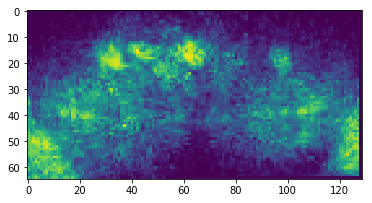

In [82]:
plt.imshow(brain[:,:,20,10])

(array([2.0784e+04, 1.6473e+04, 1.1695e+04, 8.6490e+03, 6.9580e+03,
        5.2450e+03, 4.0950e+03, 3.0920e+03, 2.5230e+03, 2.0560e+03,
        1.6180e+03, 1.2940e+03, 1.1040e+03, 8.9500e+02, 7.6100e+02,
        5.7400e+02, 4.6800e+02, 3.0300e+02, 2.8200e+02, 2.5100e+02,
        1.6500e+02, 1.3600e+02, 1.1900e+02, 9.2000e+01, 9.1000e+01,
        4.2000e+01, 4.4000e+01, 3.2000e+01, 2.1000e+01, 2.5000e+01,
        2.3000e+01, 1.4000e+01, 1.4000e+01, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 5.0000e+00, 5.0000e+00, 9.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.00215328, 0.00430656, 0.00645984, 0.00861312,
        0.0107664 , 0.01291968, 0.01507296, 0.01722624, 0.01937952,
        0.0215328 , 0.02368608, 0.02583936, 0.02799264, 0.03014592,
        0.0322992 , 0.03445248, 0.03660576, 0.03875904, 0.04091232,
        0.0430656 , 0.04521888, 0.04737216, 0.

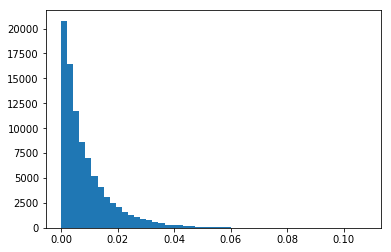

In [62]:
plt.hist(df['speed'], bins = 50)

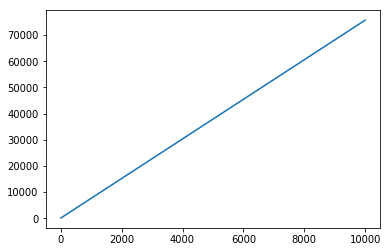

In [58]:
plt.plot(timestamps_flat[:10000])

In [34]:
raw_fictrac_times

array([0.00000e+00, 2.00000e+01, 4.00000e+01, ..., 1.79994e+06,
       1.79996e+06, 1.79998e+06])

In [45]:
fictrac_interp[:100]

array([[0.00133964, 0.00219922, 0.00305879, ..., 0.00074376, 0.00085409,
        0.00074002],
       [0.00129615, 0.00133133, 0.00108424, ..., 0.00103048, 0.00080689,
        0.0005833 ],
       [0.00039315, 0.00043029, 0.00046743, ..., 0.00042507, 0.00046505,
        0.00037247],
       ...,
       [0.000792  , 0.00075597, 0.00071995, ..., 0.00049251, 0.00042764,
        0.00050514],
       [0.00074059, 0.00066095, 0.00082974, ..., 0.00338834, 0.00350128,
        0.00361422],
       [0.00122621, 0.00120313, 0.00118005, ..., 0.00600691, 0.00570944,
        0.00483739]])

In [21]:
raw_fictrac_times[-1]

1799980.0

In [26]:
np.shape(timestamps)

(5805, 41)

In [25]:
np.shape(fictrac_interp)

(5805, 41)

In [30]:
np.shape(nib_brain)

(65, 129, 41, 5805)

In [98]:
t1s = []
t2s = []
t3s = []
t4s = []
t5s = [time()]
motCorr_brain = []
#for i in range(np.shape(nib_brain)[3]):
t0 = time()
for i in range(10):
    print(i)
    t1s.append(time())
    brain_slice = ants.from_numpy(nib_brain[:,:,:,i])
    t2s.append(time())
    motCorr_slice = ants.registration(meanbrain, brain_slice, type_of_transform='SyN')
    t3s.append(time())
    motCorr_slice = motCorr_slice['warpedmovout'].numpy()[:,:,z]
    t4s.append(time())
    motCorr_brain.append(motCorr_slice)
    if len(t5s)<10:
        t5s.append(time())

        
t1s = np.asarray(t1s)
t2s = np.asarray(t2s)
t3s = np.asarray(t3s)
t4s = np.asarray(t4s)
t5s = np.asarray(t5s)

print('t1:', np.mean(t1s-t5s))
print('t2:', np.mean(t2s-t1s))
print('t3:', np.mean(t3s-t2s))
print('t4:', np.mean(t4s-t3s))
print('t5:', np.mean(t5s-t4s))

0
1
2
3
4
5
6
7
8
9
t1: 0.0001726388931274414
t2: 0.0018339872360229493
t3: 2.993111252784729
t4: 0.0004848957061767578
t5: -2.995602774620056


In [68]:
nib_brain_slice = nib_brain[:,:,:,0]
brain_slice = ants.from_numpy(nib_brain_slice)

In [100]:
(3*5000)/60/60

4.166666666666667

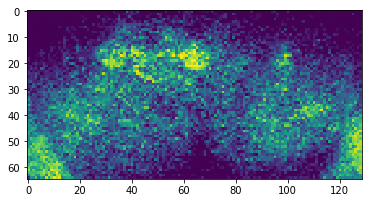

In [21]:
plt.imshow(nib_brain[:,:,20,1000])

In [54]:
np.shape(meanbrain)

(65, 129, 41)

In [67]:
ants.viz.surface(meanbrain)

TypeError: 'module' object is not callable

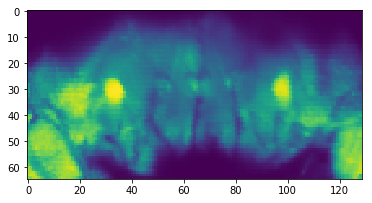

In [31]:
plt.imshow(meanbrain[:,:,10])

In [ ]:
'matrix_to_images',

In [69]:
motCorr_brain = ants.registration(meanbrain, brain_slice, type_of_transform='SyN', verbose=True)

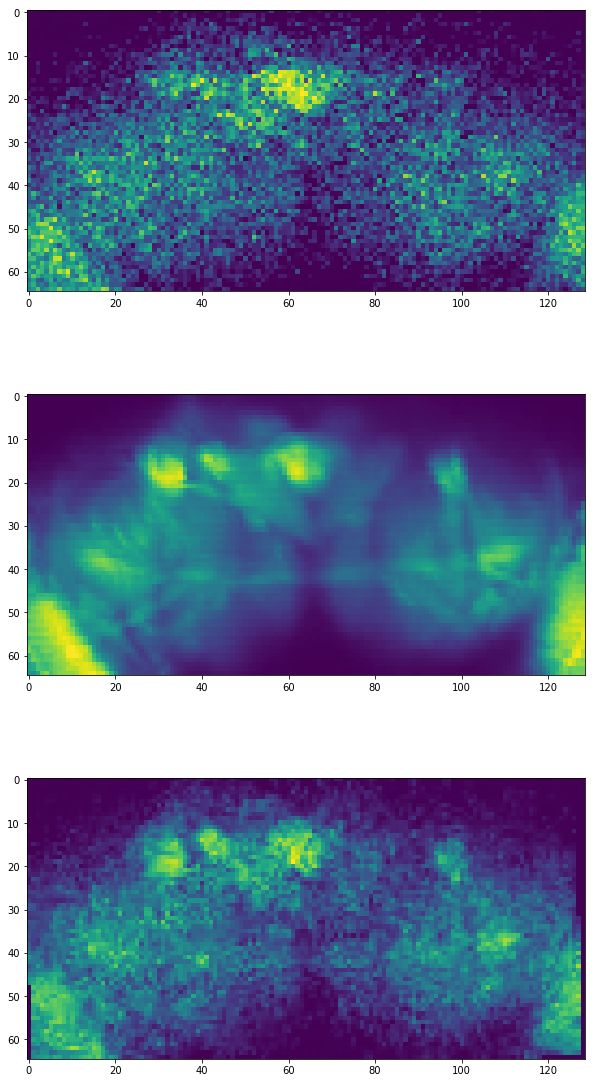

In [90]:
z=20
fig = plt.figure(figsize=(10,20))

plt.subplot(3,1,1)
plt.imshow(brain_slice[:,:,z])

plt.subplot(3,1,2)
plt.imshow(meanbrain[:,:,z])

plt.subplot(3,1,3)
plt.imshow(motCorr_brain['warpedmovout'].numpy()[:,:,z])

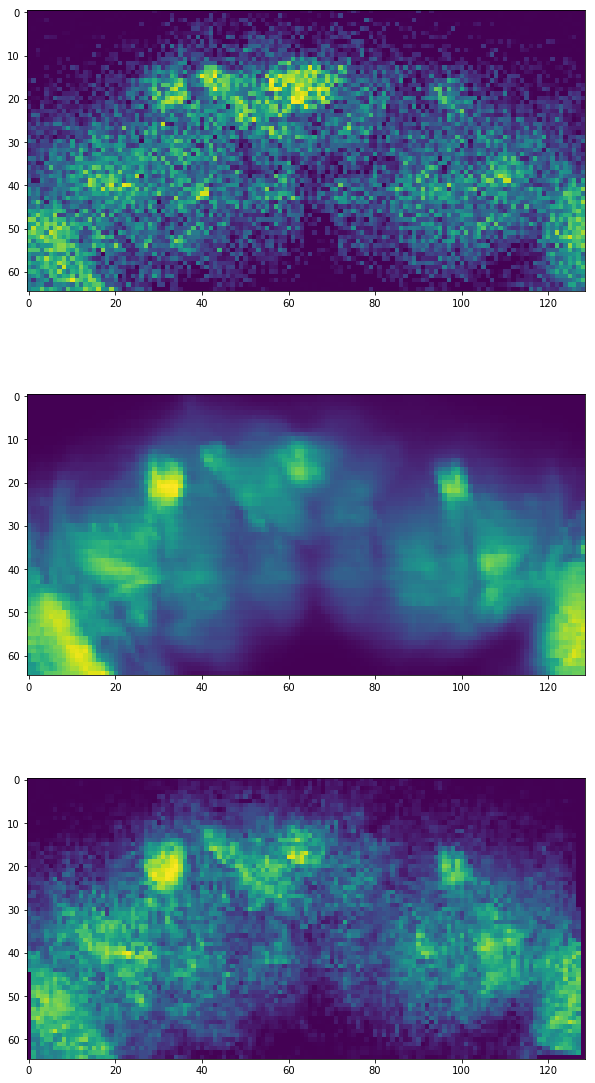

In [93]:
z=18
fig = plt.figure(figsize=(10,20))

plt.subplot(3,1,1)
plt.imshow(brain_slice[:,:,z])

plt.subplot(3,1,2)
plt.imshow(meanbrain[:,:,z])

plt.subplot(3,1,3)
plt.imshow(motCorr_brain['warpedmovout'].numpy()[:,:,z])

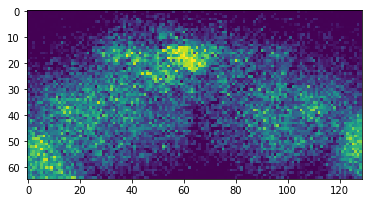

In [80]:
plt.imshow(brain_slice[:,:,20])

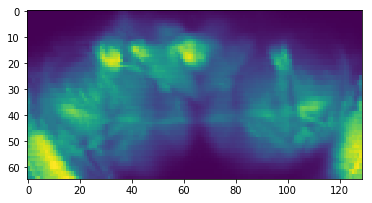

In [81]:
plt.imshow(meanbrain[:,:,20])

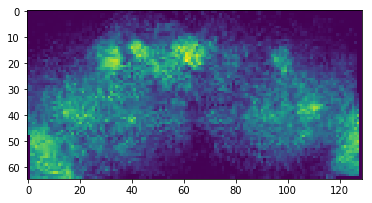

In [79]:
plt.imshow(motCorr_brain['warpedmovout'].numpy()[:,:,20])

In [76]:
dir(ants.viz.plot)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

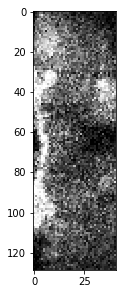

In [73]:
brain_slice.plot()

In [ ]:
motCorr_brain

In [46]:
motCorr_brain['warpedfixout']

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (65, 129, 41, 5805)
	 Spacing    : (1.0, 1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [24]:
dir(ants)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'abp_n4',
 'affine_initializer',
 'allclose',
 'ants_image',
 'ants_image_io',
 'ants_metric',
 'ants_metric_io',
 'ants_transform',
 'ants_transform_io',
 'apply_ants_transform',
 'apply_ants_transform_to_image',
 'apply_ants_transform_to_point',
 'apply_ants_transform_to_vector',
 'apply_transforms',
 'atropos',
 'bias_correction',
 'channels',
 'compose_ants_transforms',
 'convolve_image',
 'copy_image_info',
 'core',
 'create_ants_metric',
 'create_ants_transform',
 'create_jacobian_determinant_image',
 'create_tiled_mosaic',
 'create_warped_grid',
 'crop_image',
 'crop_indices',
 'decomposition',
 'decrop_image',
 'denoise_image',
 'eig_seg',
 'from_numpy',
 'fsl2antstransform',
 'get_ants_data',
 'get_ants_data_files',
 'get_ants_transform_fixed_parameters',
 'get_ants_transform_parameters',
 'get_center_of_mass',
 'get_centroids',
 'get_

In [5]:
ants.plot(brain)

Exception: Unable to show 3D-vector Image

In [6]:
brain = ants.image_read(brain_file, pixeltype='float')

ValueError: unsupported pixeltype short

In [4]:
brain = ants.image_read(ants.get_ants_data(brain_file))

ValueError: ('File doesnt exist. Options: ', ['r16slice.jpg', 'softwareVersions.csv', 'mni.nii.gz', 'surface.nii.gz', 'mnia.nii.gz', 'r62slice.jpg', 'oasis_mni.nii.gz', 'r64slice.jpg', 'simple.jpg', 'r27slice.jpg', 'powers_mni_itk.csv', 'surf.nii.gz', 'r30slice.jpg', 'function.nii.gz', 'ch2.nii.gz', 'r85slice.jpg'])

In [3]:
fname1 = ants.get_ants_data('r16')
fname2 = ants.get_ants_data('r64')
print(fname1)

/home/users/brezovec/.antspy/r16slice.jpg


In [4]:
img1 = ants.image_read(fname1)
img2 = ants.image_read(fname2)
print(img1)

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]



In [5]:
arr_4d = np.random.randn(70,70,70,10).astype('float32')
img_fmri = ants.from_numpy(arr_4d, has_components=True)
print(img_fmri)

ANTsImage
	 Pixel Type : float
	 Components : 10
	 Dimensions : (70, 70, 70)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



In [6]:
# clone
img = ants.image_read(fname1)
img2 = img.clone()

# convert to numpy
img_arr = img.numpy()

# create another image with same properties but different data
img2 = img.new_image_like(img_arr*2)

# save to file
# img.to_file(...)

# many useful things:
img.median()
img.std()
img.argmin()
img.argmax()
img.flatten()
img.nonzero()
img.unique()

# do any operations directly on ANTsImage types
img3 = img2 - img
img3 = img2 > img
img3 = img2 / img
img3 = img2 == img


# change any physical properties
img4 = img.clone()
print(img4.spacing)
img4.set_spacing((1,1))
print(img4.spacing)

# test if two images are allclose in values
issame = ants.allclose(img,img2)

# test if two images have same physical space
issame_phys = ants.image_physical_space_consistency(img,img2)

(1.0, 1.0)
(1.0, 1.0)


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/core/ants_image.py:404: RuntimeWarning: invalid value encountered in true_divide
  new_array = this_array / other


dict_keys(['segmentation', 'probabilityimages'])


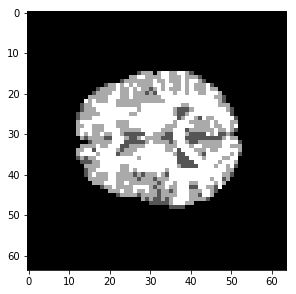

In [7]:
img = ants.image_read(ants.get_ants_data('r16'))
img = ants.resample_image(img, (64,64), 1, 0)
mask = ants.get_mask(img)
img_seg = ants.atropos(a=img, m='[0.2,1x1]', c='[2,0]', 
                       i='kmeans[3]', x=mask)
print(img_seg.keys())
ants.plot(img_seg['segmentation'])

In [8]:
brain_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20181217/fly2/anatomy/TSeries-12172018-1322-002.nii'

In [9]:
t1 = time()
nib_brain = nib.load(brain_file).get_data()
nib_brain = np.swapaxes(nib_brain, 0, 1)
brain = ants.from_numpy(nib_brain)
t2 = time()
print('time:', t2-t1)

time: 15.185147285461426


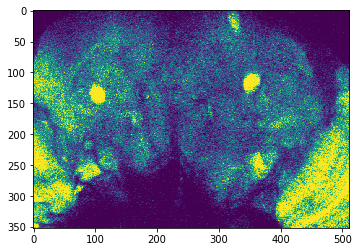

In [11]:
plt.imshow(nib_brain[:,:,100,0])

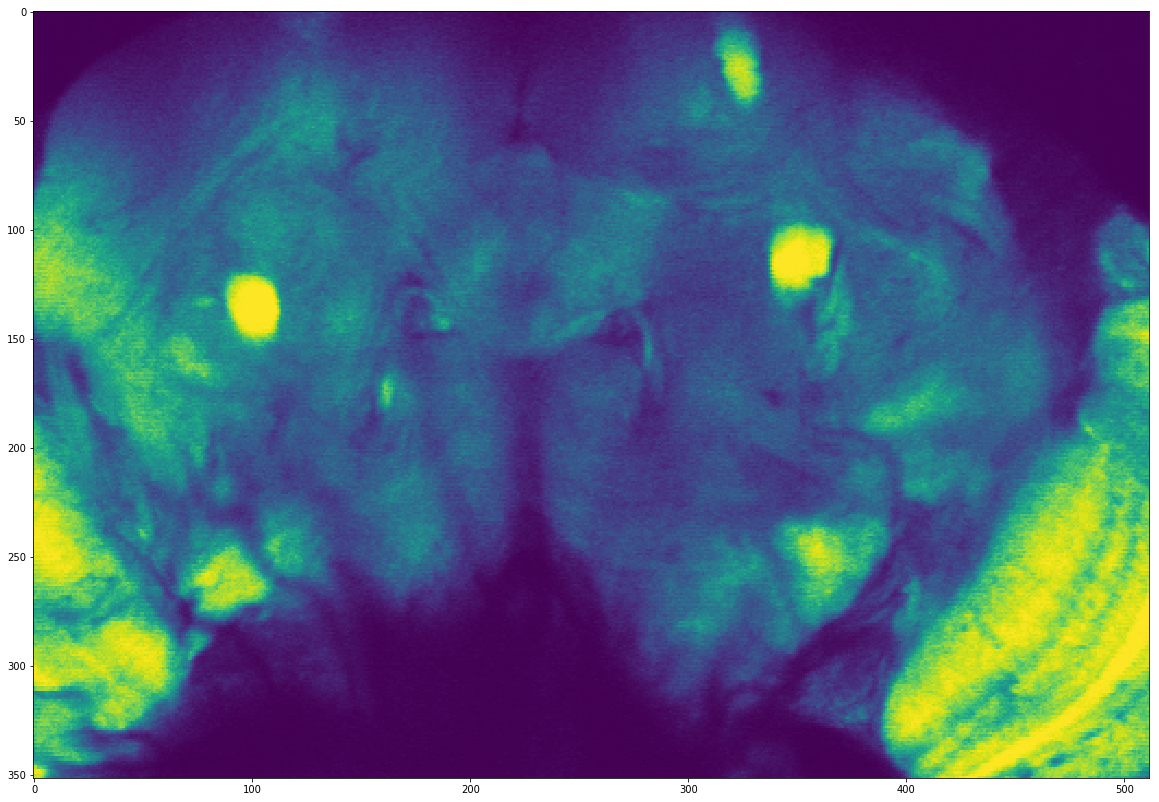

In [17]:
fig = plt.figure(figsize=(20,20))
plt.imshow(meanbrain[:,:,100])

In [10]:
nib_brain.shape

(352, 512, 271, 29)

In [18]:
meanbrain = brain.mean(3)
meanbrain = ants.from_numpy(meanbrain)

In [53]:
motCorr_brain = []
t0 = time()
for i in range(np.shape(nib_brain)[3]):
    print(i)
    brain_slice = ants.from_numpy(nib_brain[:,:,:,i])
    motCorr_slice = ants.registration(meanbrain, brain_slice, type_of_transform='QuickRigid')
    motCorr_slice = motCorr_slice['warpedmovout'].numpy()
    motCorr_brain.append(motCorr_slice)
    
#np.save(save_file, motCorr_brain)
print(time()-t0)

0
0.0003190040588378906
0.5601434707641602
25.19920778274536
25.41342544555664
25.41380262374878
1
25.413887977600098
25.98303198814392


KeyboardInterrupt: 

In [56]:
brain_slice.dtype

'float32'

In [57]:
brain_slice

ANTsImage
	 Pixel Type : float
	 Components : 1
	 Dimensions : (352, 512, 271)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [52]:
t0 = time()
motCorr_slice = motCorr_slice['warpedmovout'].numpy()
print(time()-t0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [48]:
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "2"

In [40]:
threading.active_count()

6

In [29]:
print(os.environ.get("ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS"))

None


In [35]:
%env ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=1

env: ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=1


In [25]:
ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS = 1

In [ ]:
motCorr_brain = np.moveaxis(np.asarray(motCorr_brain),0,3)
motCorr_brain_ants = ants.from_numpy(motCorr_brain)